In [1]:
!pip install transformers

     |████████████████████████████████| 4.0MB 4.5MB/s eta 0:00:01
     |████████████████████████████████| 40kB 4.6MB/s  eta 0:00:01
     |████████████████████████████████| 901kB 38.1MB/s eta 0:00:01
     |████████████████████████████████| 6.6MB 32.6MB/s eta 0:00:01
     |████████████████████████████████| 71kB 2.9MB/s  eta 0:00:01
ERROR: allennlp 0.9.0 requires flaky, which is not installed.
ERROR: allennlp 0.9.0 requires responses>=0.7, which is not installed.
ERROR: chainer 6.5.0 has requirement typing-extensions<=3.6.6, but you'll have typing-extensions 4.1.1 which is incompatible.
ERROR: allennlp 0.9.0 has requirement spacy<2.2,>=2.1.0, but you'll have spacy 2.2.3 which is incompatible.
  Found existing installation: packaging 19.2
    Uninstalling packaging-19.2:
      Successfully uninstalled packaging-19.2
  Found existing installation: typing-extensions 3.6.6
    Uninstalling typing-extensions-3.6.6:
      Successfully uninstalled typing-extensions-3.6.6


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/yelp-dataset/Dataset_User_Agreement.pdf
/kaggle/input/yelp-dataset/yelp_academic_dataset_review.json
/kaggle/input/yelp-dataset/yelp_academic_dataset_checkin.json
/kaggle/input/yelp-dataset/yelp_academic_dataset_business.json
/kaggle/input/yelp-dataset/yelp_academic_dataset_tip.json
/kaggle/input/yelp-dataset/yelp_academic_dataset_user.json


In [3]:
import torch
from transformers.data.processors.utils import InputExample
from torch import nn
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import Adam
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm, tnrange 
import time 

In [54]:
reader = pd.read_json('/kaggle/input/yelp-dataset/yelp_academic_dataset_review.json', lines=True, chunksize=20000)

In [55]:
def generate_dataset(json_reader, nrows=20000, min_length=1, max_length = 128):
    df = None
    while True:
        df_candidate = next(json_reader)
        df_candidate = df_candidate.loc[(df_candidate['text'].str.len() > min_length) & (df_candidate['text'].str.len() <= max_length), ['text', 'stars']]
        if df is None:
            df = df_candidate
        else:
            df = df.append(df_candidate)
        for rating in range(1, 6, 1):
            df_rating = df[df['stars'] == rating]
            if len(df_rating) > nrows//5:
                df_rating = df_rating.iloc[:nrows//5, :]
                df = df.loc[~(df['stars'] == rating), :]
                df = df.append(df_rating)
        if len(df) == nrows:
            return df

In [56]:
%%time
train_df = generate_dataset(reader)
test_df = generate_dataset(reader)

CPU times: user 41.3 s, sys: 1.79 s, total: 43.1 s
Wall time: 47 s


In [57]:
train_df['stars'].value_counts()

5    4000
4    4000
3    4000
2    4000
1    4000
Name: stars, dtype: int64

In [58]:
test_df['stars'].value_counts()

5    4000
4    4000
3    4000
2    4000
1    4000
Name: stars, dtype: int64

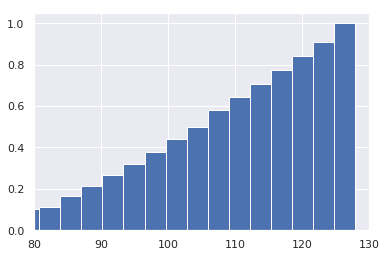

In [62]:
plt.hist(train_df['text'].str.len().tolist() + test_df['text'].str.len().tolist(),cumulative=True, density=True, bins=40)
plt.xlim(left=80, right=130) 
plt.show()

In [63]:
train_df.head()

,text,stars
359,They served me a frozen pizza and skunked beer...,1
450,One of the worst places in Tucson! Cold food ...,1
1015,High pressure tea sales! Good teas but outrag...,1
1175,"Sat down over a half hour, only miso and drink...",1
1478,"If you're a Latino, you're best staying away f...",1


In [64]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [65]:
hidden_size = 200

In [13]:
from transformers import BertTokenizer,BertForSequenceClassification,glue_convert_examples_to_features,DistilBertTokenizer,DistilBertForSequenceClassification

In [14]:
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-multilingual-cased")
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-multilingual-cased", num_labels=hidden_size)
# tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
# model = BertForSequenceClassification.from_pretrained('bert-base-cased', num_labels=hidden_size)
# model = mode.cuda()
model.classifier.add_module('activation', nn.Tanh())
model.classifier.add_module('prediction', nn.Linear(hidden_size, 5))

FINE_TUNE = True
print(f'Total model trainable parameters {count_parameters(model)}')
if FINE_TUNE:
    for param in model.distilbert.parameters():
        param.requires_grad = False

    for param in model.classifier.parameters():
        param.requires_grad = True
    print(f'Total head trainable parameters {count_parameters(model)}')
model.cuda();

Some weights of the model checkpoint at distilbert-base-multilingual-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['pre_classifier.weight', 'classif

Total model trainable parameters 135479477
Total head trainable parameters 745397


In [15]:
print(model)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
      

In [16]:
tokenized = tokenizer.tokenize(' I am parachuting with you')
print(tokenized)
print(tokenizer.encode(tokenized, add_special_tokens=False))
print(tokenizer.encode(tokenized, add_special_tokens=True))

['I', 'am', 'para', '##chu', '##ting', 'with', 'you']
[146, 10392, 10220, 22882, 12141, 10169, 13028]
[101, 146, 10392, 10220, 22882, 12141, 10169, 13028, 102]


In [25]:
# https://huggingface.co/transformers/main_classes/processors.html
def get_features(df, text_col, label_col):
    l = [InputExample(guid=idx, text_a=df.loc[idx, text_col], label=df.loc[idx, label_col]) for 
       idx, row in tqdm(df.iterrows(), total=df.shape[0])]
    features = glue_convert_examples_to_features(examples=l, 
                                    tokenizer=tokenizer,
                                    max_length=300,
                                    label_list = df[label_col].values,
                                    output_mode='regression')
#     print(features[0].token_type_ids)
    all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
    all_attention_mask = torch.tensor([f.attention_mask for f in features], dtype=torch.long)
#     all_token_type_ids = torch.tensor([f.token_type_ids for f in features], dtype=torch.long)
    all_labels = torch.tensor([f.label-1 for f in features], dtype=torch.long)
    dataset = TensorDataset(all_input_ids, all_attention_mask, all_labels)
    return dataset

In [26]:
train_dataset = get_features(train_df, 'text', 'stars')
test_dataset = get_features(test_df, 'text', 'stars')

In [27]:
val_idx, train_idx = train_test_split(np.arange(len(train_dataset)), random_state=4, train_size=0.1)
total_size = len(train_dataset)
val_dataset = TensorDataset(*train_dataset[val_idx])
train_dataset = TensorDataset(*train_dataset[train_idx])
assert total_size == len(val_dataset) + len(train_dataset)

In [34]:
# works
model(input_ids=train_dataset[:2][0].cuda(), 
      attention_mask=train_dataset[:2][1].cuda(), 
      labels=train_dataset[:2][2].cuda());

In [35]:
batch_size = 32
gradient_every = 64
assert batch_size <= gradient_every and gradient_every % batch_size == 0

accumulation_steps = gradient_every//batch_size

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size*2, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size*2, shuffle=False)

epochs = 25

lr = 0.01
optimizer = Adam(model.classifier.parameters(), lr=lr)  

In [36]:
tr_losses = []
v_losses = []

In [37]:
# scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_data_loader)*epochs)
for epoch in tnrange(epochs, desc='epoch'):
    """ Training stage """
    epoch_tr_losses = []
    print(f'epoch {epoch+1}')
    for k, (input_ids, attention_mask, labels) in enumerate(tqdm(train_dataloader, total=len(train_dataloader), desc='batch')):
        feed_dict = {'input_ids': input_ids.cuda(),
                     'attention_mask': attention_mask.cuda(),
                     'labels': labels.cuda()}
        
        loss, _ = model(**feed_dict,return_dict=False)
#         print(200)
#         print(model(**feed_dict).loss)
        # gradient accumulation
        epoch_tr_losses.append(loss.item())
        loss = loss/accumulation_steps
        loss.backward()
        if (k + 1) % accumulation_steps == 0:
            optimizer.step()
            model.zero_grad()

    tr_losses.append(np.mean(epoch_tr_losses))
    print(f'train NLL loss: {np.mean(epoch_tr_losses)}')
  
    """ Validation stage """
    epoch_v_losses = [] 
    with torch.no_grad():
        for k, (input_ids, attention_mask, labels) in enumerate(tqdm(val_dataloader, total=len(val_dataloader), desc='val batch')):
            feed_dict = {'input_ids': input_ids.cuda(),
                         'attention_mask': attention_mask.cuda(),
                         'labels': labels.cuda()} 

            loss, pred = model(**feed_dict,return_dict=False)
            epoch_v_losses.append(loss.item())
        v_losses.append(np.mean(epoch_v_losses))
    print(f'validation BCE loss: {np.mean(epoch_v_losses)}')
    torch.save(model.classifier.state_dict(), f'/kaggle/working/yelp-head{epoch}.pt')

epoch 1



train NLL loss: 1.5131626847787951



validation BCE loss: 1.3847303465008736
epoch 2



train NLL loss: 1.3377882834021926



validation BCE loss: 1.3184226602315903
epoch 3



train NLL loss: 1.3031690395470206



validation BCE loss: 1.3305650725960732
epoch 4



train NLL loss: 1.2686905514263938



validation BCE loss: 1.2946326434612274
epoch 5



train NLL loss: 1.2554334547925503



validation BCE loss: 1.2987436428666115
epoch 6



train NLL loss: 1.2404249549334776



validation BCE loss: 1.293568417429924
epoch 7



train NLL loss: 1.229103480247741



validation BCE loss: 1.3191779553890228
epoch 8



train NLL loss: 1.2315677827131664



validation BCE loss: 1.2885786667466164
epoch 9



train NLL loss: 1.214875801235226



validation BCE loss: 1.2667186707258224
epoch 10



train NLL loss: 1.2154148362629802



validation BCE loss: 1.2723432257771492
epoch 11



train NLL loss: 1.198042628824288



validation BCE loss: 1.2675746381282806
epoch 12



train NLL loss: 1.1975860025020355



validation BCE loss: 1.301884025335312
epoch 13



train NLL loss: 1.198656439569825



validation BCE loss: 1.2790030762553215
epoch 14



train NLL loss: 1.1900960033667003



validation BCE loss: 1.2777120843529701
epoch 15



train NLL loss: 1.1924036337551496



validation BCE loss: 1.3018886521458626
epoch 16



train NLL loss: 1.1866383527187592



validation BCE loss: 1.3287532553076744
epoch 17



train NLL loss: 1.1751849507609158



validation BCE loss: 1.2947124317288399
epoch 18



train NLL loss: 1.1710242912278954



validation BCE loss: 1.2841559275984764
epoch 19



train NLL loss: 1.1614289932639887



validation BCE loss: 1.273483321070671
epoch 20



train NLL loss: 1.1649567658174123



validation BCE loss: 1.3572630062699318
epoch 21



train NLL loss: 1.1587874959123896



validation BCE loss: 1.3806501850485802
epoch 22



train NLL loss: 1.173506925503413



validation BCE loss: 1.3082267343997955
epoch 23



train NLL loss: 1.1619837990043858



validation BCE loss: 1.2809610441327095
epoch 24



train NLL loss: 1.1593231207935522



validation BCE loss: 1.279550813138485
epoch 25



train NLL loss: 1.1542360192917762



validation BCE loss: 1.2712923735380173



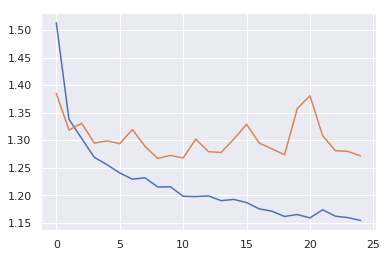

In [38]:
plt.plot(tr_losses)
plt.plot(v_losses)

In [39]:
batch_predictions, batch_actual = [], []
with torch.no_grad():
    for k, (input_ids, attention_mask, labels) in enumerate(tqdm(test_dataloader, total=len(test_dataloader), desc='val batch')):
        feed_dict = {'input_ids': input_ids.cuda(),
                     'attention_mask': attention_mask.cuda()} 
        
        pred = model(**feed_dict)[0].cpu()
        batch_predictions.append(pred.numpy())
        batch_actual.append(labels)

In [40]:
predictions = np.array([i for k in batch_predictions for i in k ])

predictions = np.argmax(predictions, axis=1)
actual = np.array([i for k in batch_actual for i in k ])

In [42]:
from sklearn.metrics import f1_score,classification_report
f1_score(actual, predictions, average='micro')

0.4505

In [43]:
print(classification_report(actual,predictions))

              precision    recall  f1-score   support

           0       0.56      0.57      0.57      2000
           1       0.39      0.38      0.38      2000
           2       0.36      0.39      0.38      2000
           3       0.39      0.38      0.38      2000
           4       0.56      0.54      0.55      2000

    accuracy                           0.45     10000
   macro avg       0.45      0.45      0.45     10000
weighted avg       0.45      0.45      0.45     10000



In [44]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')

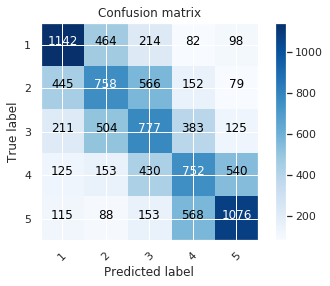

In [45]:
# compute the confusion matrix
from sklearn.metrics import confusion_matrix
import itertools
confusion_mtx = confusion_matrix(actual, predictions) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(1,6))
plt.show()